In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import os
import numpy as np
import torch
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


## Set location and object set for YCB Dataset
### YCB Object Indices

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

In [2]:
### Set this to the root of your YCB Dataset
dataset_root = '/media/DataDrive/ycb/YCB_Video_Dataset'

### If you want individual objects, change this to
### a list of the indices you want (see above).
object_list = list(range(1,22))

### Set this to the dataset subset you want
mode = 'test'

## Initalize YCB Dataset

In [3]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer

from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes


output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.IMAGE_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = object_list,
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)


## Initialize Dense Fusion Pose Estimator

In [4]:
from dense_fusion.network import PoseNet

df_weights = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
df_estimator = PoseNet(num_points = 1000, num_obj = 21)
df_estimator.load_state_dict(torch.load(df_weights, map_location=torch.device('cpu')))
df_estimator.cuda();
df_estimator.eval();

## Set Iso Bingham Regression File Paths

In [5]:
### Set this to your iso bingham network checkpoint file path
iso_model_checkpoint = '../weights/bingham_iso.pth'

## Initialize the Iso Bingham Regression Network

In [6]:
from se3_distributions.models.bingham_networks import IsoBingham
from se3_distributions.losses.bingham_loss import isoLikelihood

feature_size = 1408

iso_estimator = IsoBingham(feature_size, len(object_list))
iso_estimator.load_state_dict(torch.load(iso_model_checkpoint))
iso_estimator.eval()
iso_estimator.cuda()

def bingham_iso(img, points, choose, obj):
    q_est, t_est, feat = evaluateDenseFusion(df_estimator, img, points, choose, obj, use_global_feat=False)

    #feat = torch.Tensor(feat).unsqueeze(0).cuda()
    mean_est = torch.Tensor(q_est).unsqueeze(0).cuda()
    df_obj = torch.LongTensor(obj-1).unsqueeze(0).cuda()
    sig_est = iso_estimator(feat.unsqueeze(0).cuda(), df_obj)
    lik_est = isoLikelihood(mean_q=mean_est[0], 
                            sig=sig_est[0,0])

    return lik_est, q_est, t_est

## Full Bingham Regression File Paths

In [7]:
### Set this to your full bingham network checkpoint file path
full_model_checkpoint = '../weights/bingham_full.pth'

## Initialize the Full Bingham Regression Network

In [8]:
from se3_distributions.models.bingham_networks import DuelBingham
from se3_distributions.losses.bingham_loss import duelLikelihood

full_estimator = DuelBingham(feature_size, len(object_list))
full_estimator.load_state_dict(torch.load(full_model_checkpoint))
full_estimator.eval()
full_estimator.cuda()

def bingham_full(img, points, choose, obj):
    q_est, t_est, feat = evaluateDenseFusion(df_estimator, img, points, choose, obj, use_global_feat=False)

    #feat = torch.Tensor(feat).unsqueeze(0).cuda()
    mean_est = torch.Tensor(q_est).unsqueeze(0).cuda()
    df_obj = torch.LongTensor(obj-1).unsqueeze(0).cuda()

    duel_est, z_est = full_estimator(feat, df_obj)

    lik_est = duelLikelihood(mean_q=mean_est[0], 
                             duel_q = duel_est[0,0],
                             z=z_est[0])

    return lik_est, q_est, t_est

## Sample Dataset and Estimate Likelihood Distribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Likelihood of Ground Truth: 0.34512
Likelihood of Estimate: 0.41405


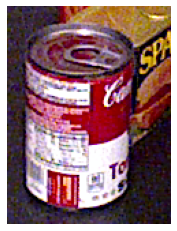

In [13]:
%matplotlib inline 
from object_pose_utils.utils.display import torch2Img
from se3_distributions.utils.evaluation_utils import evaluateDenseFusion

index = np.random.randint(len(dataset))

obj, quat, trans, img, points, choose = dataset[index]
lik_est, q_est, t_est = bingham_iso(img, points, choose, obj)

lik_gt = lik_est(quat.unsqueeze(0).cuda()).item()
lik_out = lik_est(torch.from_numpy(q_est).unsqueeze(0).cuda()).item()

print('Likelihood of Ground Truth: {:0.5f}'.format(lik_gt))
print('Likelihood of Estimate: {:0.5f}'.format(lik_out))
plt.imshow(torch2Img(img, normalized=True))
plt.axis('off')
plt.show()

## Build Orientaion Gridding for Visualization

In [14]:
from object_pose_utils.bbTrans.discretized4dSphere import S3Grid
grid = S3Grid(2)
grid.Simplify()
grid_vertices = grid.vertices

## Visualize Distribution

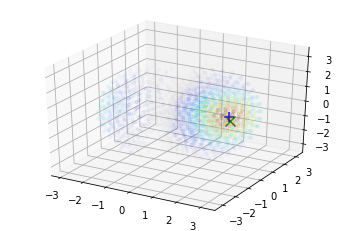

In [15]:
#%matplotlib notebook 
from object_pose_utils.utils.display import scatterSO3, quats2Point

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

grid_lik = lik_est(torch.from_numpy(grid_vertices).float().cuda()).flatten()
scatterSO3(grid_vertices, to_np(grid_lik), ax=ax, alims = [0,.25], s=10)
gt_pt = quats2Point([to_np(quat)])
est_pt = quats2Point([q_est])
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g',s=100, marker='x')
ax.scatter(est_pt[:,0], est_pt[:,1], est_pt[:,2], c='b',s=100, marker='+')
plt.show()